In [1]:
!export HF_HOME=/run/media/anton/hdd/hf

In [1]:
import os
import diffusers
import torch

from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from torch.autograd.functional import jacobian

import matplotlib.pyplot as plt

import numpy as np
import matplotlib.pyplot as plt

from diffusers import DDPMPipeline, UNet2DModel

from urllib.request import urlopen 
import json 




os.environ['HF_HOME'] = "/run/media/anton/hdd/hf"

device = "cuda:0" if torch.cuda.is_available() else "cpu"

model_id = "google/ddpm-cifar10-32"

ddpm = DDPMPipeline.from_pretrained(model_id) 
ddpm = ddpm.to(device)
image = ddpm().images[0]
image.save("ddpm_cifar10_generated.png")

/home/anton/source/torch-env/lib/python3.12/site-packages/diffusers/models/transformers/transformer_2d.py:34: FutureWarning: `Transformer2DModelOutput` is deprecated and will be removed in version 1.0.0. Importing `Transformer2DModelOutput` from `diffusers.models.transformer_2d` is deprecated and this will be removed in a future version. Please use `from diffusers.models.modeling_outputs import Transformer2DModelOutput`, instead.
  deprecate("Transformer2DModelOutput", "1.0.0", deprecation_message)


Loading pipeline components...:   0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

In [2]:
random=False

if random:
    # create random unet
    unet_config_url = "https://huggingface.co/google/ddpm-cifar10-32/raw/main/config.json"
    response = urlopen(unet_config_url) 
    data_json = json.loads(response.read()) 
    unet_random = UNet2DModel(**data_json)
    
    # add to pipeline
    ddpm_random = DDPMPipeline(unet=unet_random, scheduler=ddpm.scheduler)
    ddpm = ddpm_random.to(device)

In [3]:
ddpm

DDPMPipeline {
  "_class_name": "DDPMPipeline",
  "_diffusers_version": "0.29.1",
  "_name_or_path": "google/ddpm-cifar10-32",
  "scheduler": [
    "diffusers",
    "DDPMScheduler"
  ],
  "unet": [
    "diffusers",
    "UNet2DModel"
  ]
}

In [4]:
ddpm.scheduler

DDPMScheduler {
  "_class_name": "DDPMScheduler",
  "_diffusers_version": "0.29.1",
  "beta_end": 0.02,
  "beta_schedule": "linear",
  "beta_start": 0.0001,
  "clip_sample": true,
  "clip_sample_range": 1.0,
  "dynamic_thresholding_ratio": 0.995,
  "num_train_timesteps": 1000,
  "prediction_type": "epsilon",
  "rescale_betas_zero_snr": false,
  "sample_max_value": 1.0,
  "steps_offset": 0,
  "thresholding": false,
  "timestep_spacing": "leading",
  "trained_betas": null,
  "variance_type": "fixed_large"
}

## Sample data

Files already downloaded and verified


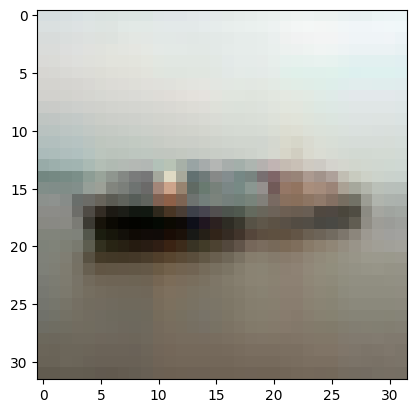

In [5]:
dataset_train = datasets.CIFAR10("data", train=True, download=True, transform=transforms.Compose([transforms.ToTensor()]))
training_data_loader = DataLoader(dataset_train, batch_size=1, shuffle=True)
image, y = next(iter(training_data_loader))

image = image.to(device)

plt.imshow(np.moveaxis(image[0].cpu().numpy(), 0, -1))

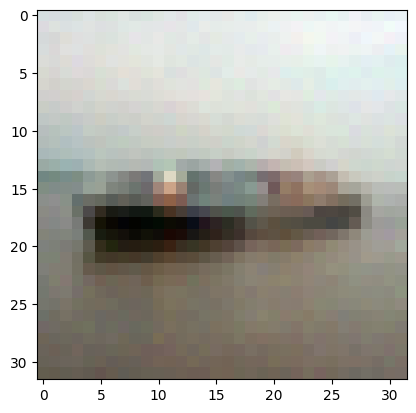

In [6]:
beta_start=1e-4
beta_end=2e-2
steps=1000
t=2

betas = torch.arange(start=beta_start, end=beta_end, step=(beta_end - beta_start)/steps)
alphas = 1 - betas
alphas_prod = torch.cumprod(alphas, dim=0).to(device)

def add_noise(image, t, rescaled=False, return_beta=False):

    noise = torch.randn(image.shape).to(device)

    image_scaled = 2 * image - 1

    image_noisy = torch.sqrt(alphas_prod[t]) * image_scaled + torch.sqrt(1 - alphas_prod[t]) * noise

    if rescaled:
        image_noisy = torch.clip(image_noisy / 2 + 0.5, min=0, max=1)

    if return_beta:
        return image_noisy, betas[t]
    
    return image_noisy


image_noisy = add_noise(image=image, t=t, rescaled=True)

plt.imshow(np.moveaxis(image_noisy[0].cpu().numpy(), 0, -1))

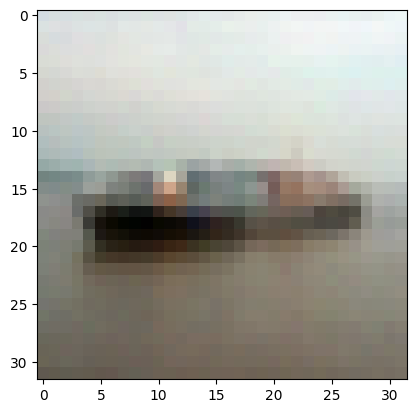

In [7]:
def denoise(image_noisy, t, rescaled=True):
    ## noisy image should be scaled [-1,1] 
    noise_pred = ddpm.unet(image_noisy, t).sample 

    mu_t = 1 / torch.sqrt(alphas[t]) * (image_noisy - (betas[t] / torch.sqrt(1 - alphas_prod[t])) * noise_pred)

    if rescaled: 
        return torch.clip(mu_t / 2 + 0.5, min=0, max=1)

    return mu_t

image_noisy = add_noise(image=image, t=t, rescaled=False)
image_denoised = denoise(image_noisy, t, rescaled=True)

plt.imshow(np.moveaxis(image_denoised[0].detach().cpu().numpy(), 0, -1))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.4395102..2.2157006].


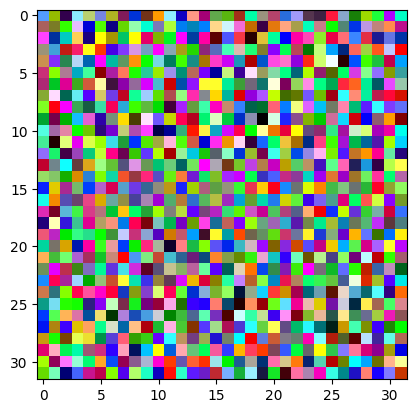

In [8]:
image_noisy = add_noise(image=image, t=t, rescaled=False)
noise_pred = ddpm.unet(image_noisy, t).sample / 2 + 0.5
plt.imshow(np.moveaxis(noise_pred[0].detach().cpu().numpy(), 0, -1))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.0047057867..0.9792784].


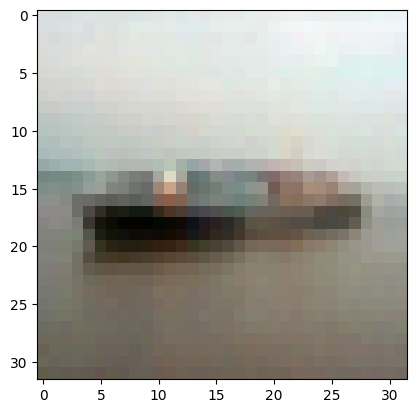

In [10]:
def noise_as_vector(x):
    x = torch.reshape(x, (1,3,32,32))
    out = ddpm.unet(x, t).sample
    return torch.reshape(out, (3072,))

def denoise_as_vector(x):
    x = torch.reshape(x, (1,3,32,32))
    pred = denoise(x, t, rescaled=False)
    return torch.reshape(pred, (3072,))

img_noisy_v = torch.reshape(image_noisy, (3072,)).to(device)

img_denoised_v = denoise_as_vector(img_noisy_v)

plt.imshow(np.moveaxis(torch.reshape(img_denoised_v / 2 + 0.5, (1,3,32,32))[0].detach().cpu().numpy(), 0, -1))

In [12]:
from torch.autograd.functional import jacobian

J_trained = jacobian(denoise_as_vector, inputs=img_noisy_v)

In [13]:
# eig = torch.linalg.eig(J_trained)
svd = torch.svd(J_trained)

In [14]:
# plt.plot(sorted(eig.eigenvalues.detach().cpu().numpy(), reverse=True))

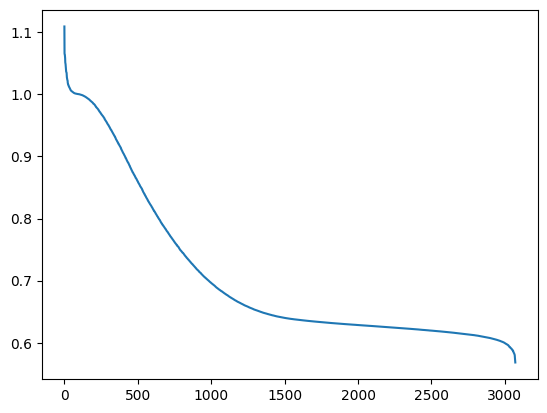

In [15]:
U = svd.U.detach().cpu().numpy()
S = svd.S.detach().cpu().numpy()
V = svd.V.detach().cpu().numpy()

plt.plot(S)

#U[0].shape

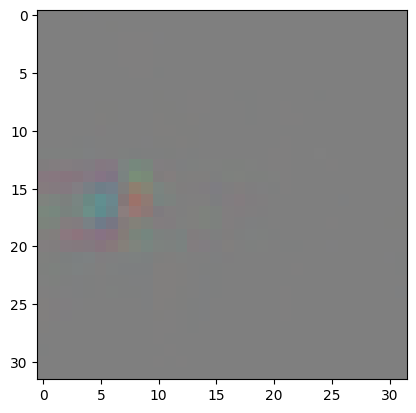

In [24]:
top_sv = U[:, 0]

top_sv_tensor = torch.reshape(torch.tensor(top_sv), (3, 32, 32)) / 2 + 0.5

plt.imshow(np.moveaxis(top_sv_tensor.numpy(), 0, -1))

In [20]:
torch.norm(J_trained - torch.diag(torch.diagonal(J_trained, 0)), p="fro")

tensor(244.3651, device='cuda:0')

In [21]:
torch.norm(svd.U @ svd.V.t(), p="fro")

tensor(55.4488, device='cuda:0')

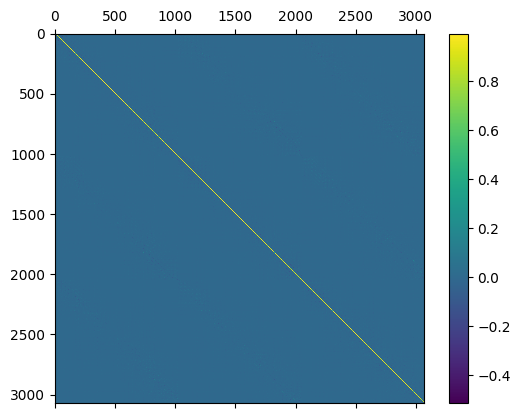

In [22]:
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(svd.U.cpu() @ svd.V.t().cpu(), interpolation='nearest')
fig.colorbar(cax)

In [24]:
torch.norm(svd.U @ svd.V.t() - torch.eye(3072).to(device), p="fro")

tensor(20.1822, device='cuda:0')

## Comparison with data

In [58]:
from datasets import load_dataset
from torchvision.transforms import Compose, PILToTensor, ConvertImageDtype

cifar10 = load_dataset("uoft-cs/cifar10", split = "train", cache_dir="/run/media/anton/hdd/hf", streaming=True)
cifar10_iterator = iter(cifar10)

def transform(image):
    transform = Compose([
        PILToTensor(),
        ConvertImageDtype(torch.float)
    ])
    return transform(image)

top_sv_similarity = []

for i, data in enumerate(cifar10):
    image = transform(data["img"])
    

    similarity = torch.sum((top_sv_tensor / torch.norm(top_sv_tensor)) * image / torch.norm(image))
    # similarity = torch.norm(top_sv_tensor - image) 
    
    top_sv_similarity.append(similarity)

    print(i) if i%1000==0 else None

0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000
22000
23000
24000
25000
26000
27000
28000
29000
30000
31000
32000
33000
34000
35000
36000
37000
38000
39000
40000
41000
42000
43000
44000
45000
46000
47000
48000
49000


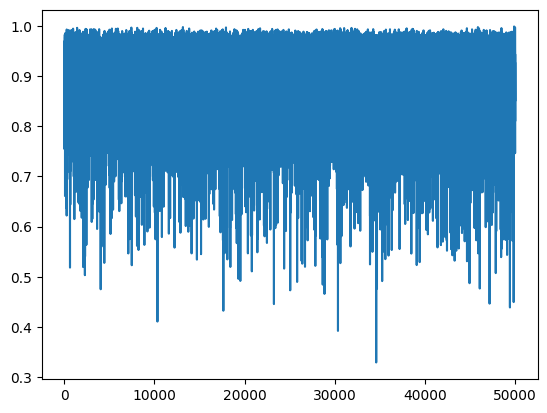

In [61]:
np.argmin(top_sv_similarity)
plt.plot(top_sv_similarity)

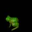

In [62]:
cifar10_iterator = iter(cifar10)

index_similar = np.argmin(top_sv_similarity)

for i, data in enumerate(cifar10):
    if i == index_similar:
        img = data["img"]
        break

img

## Loop through Jacobian computation



In [22]:
list(range(2, 50, 3))

[2, 5, 8, 11, 14, 17, 20, 23, 26, 29, 32, 35, 38, 41, 44, 47]

In [15]:
times = [1] + list(range(2, 50, 3)) + list(range(50, 1000, 50))

sv_out = {}

for t in times:
    image_noisy = add_noise(image, t)
    img_noisy_v = torch.reshape(image_noisy, (3072,)).to(device)

    def denoise_as_vector(x):
        x = torch.reshape(x, (1,3,32,32))
        pred = denoise(x, t, rescaled=False)
        print(t)
        return torch.reshape(pred, (3072,))

    J_trained = jacobian(denoise_as_vector, inputs=img_noisy_v)
    
    svd = torch.svd(J_trained)
    
    sv_sorted = sorted(svd.S.detach().cpu(), reverse=True)
    # sv_out.append(sv_sorted)
    sv_out[t] = sv_sorted

1
2
5
8
11
14
17
20
23
26
29
32
35
38
41
44
47
50
100
150
200
250
300
350
400
450
500
550
600
650
700
750
800
850
900
950


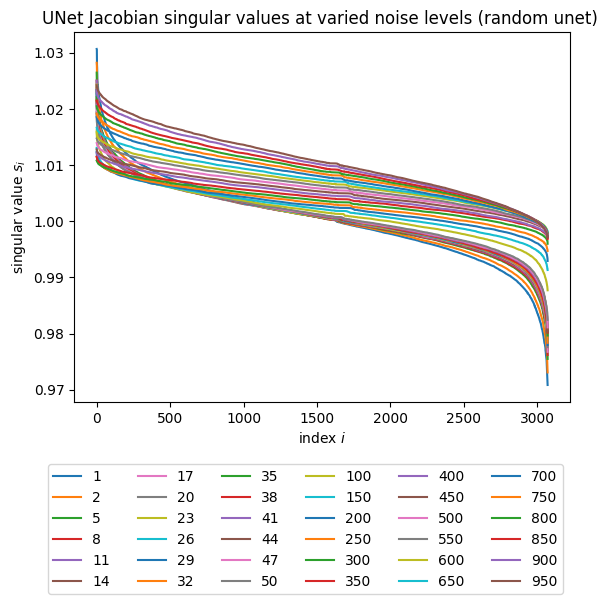

In [17]:
#for t in times[0::3]:
for t in times:

    # if t > 1: plt.plot(CURR_OUT[t], label=t)
    plt.plot(torch.tensor(sv_out[t]), label=t)
    # plt.plot(sv, label=t)
plt.title("UNet Jacobian singular values at varied noise levels (random unet) ")
plt.ylabel("singular value $s_i$")
plt.xlabel("index $i$")
plt.legend(bbox_to_anchor=(1, -0.15), ncols=6)

[1, 2, 5, 8, 11, 14, 17, 20, 23, 26, 29, 32, 35, 38, 41, 44, 47, 50, 100, 150, 200, 250, 300, 350, 400, 450, 500, 550, 600, 650, 700, 750, 800, 850, 900, 950]
[tensor(29.6123), tensor(32.8315), tensor(42.3610), tensor(44.2449), tensor(46.4620), tensor(45.3899), tensor(45.8334), tensor(46.8766), tensor(49.7394), tensor(49.6465), tensor(49.8605), tensor(48.2132), tensor(50.0173), tensor(50.8301), tensor(51.3355), tensor(51.9320), tensor(51.7988), tensor(51.3783), tensor(53.5124), tensor(54.2994), tensor(54.0814), tensor(54.4870), tensor(54.1571), tensor(54.4457), tensor(54.5635), tensor(54.5252), tensor(54.5830), tensor(54.6982), tensor(54.8420), tensor(54.8886), tensor(55.0075), tensor(55.0294), tensor(55.1557), tensor(55.3035), tensor(55.3603), tensor(55.3630)]


Text(0.5, 0, 'noise level')

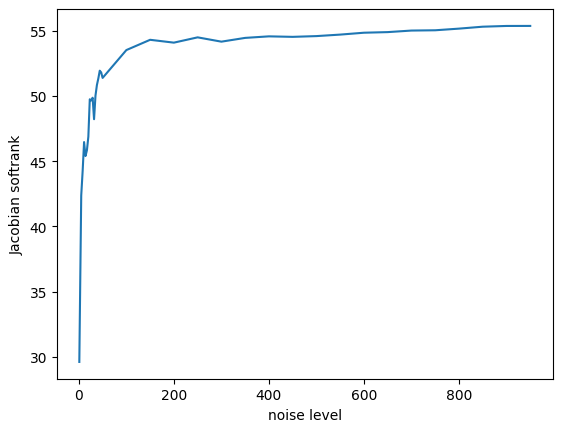

In [61]:
def softrank(sv):
    sv_sorted = sorted(sv, reverse=True)
    return torch.norm(torch.stack(sv_sorted)) / sv_sorted[0]

print(times)
softranks = [softrank(sv_out[t]) for t in times]
print(softranks)
plt.plot(times, softranks)
plt.ylabel("Jacobian softrank")
plt.xlabel("noise level")

Text(0.5, 0, 'noise level')

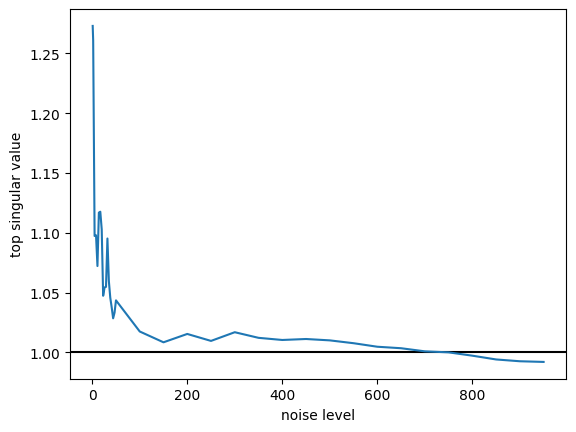

In [62]:
top = [sv_out[t][0] for t in times]
plt.axhline(1, color="black")
plt.plot(times, top)

plt.ylabel("top singular value")
plt.xlabel("noise level")

In [101]:
sv_cov = {}
J_trace = {}

for t in times:
    image_noisy, beta_t = add_noise(image, t, return_beta=True)
    img_noisy_v = torch.reshape(image_noisy, (3072,)).to(device)

    def evaluate_as_vector(x):
        x = torch.reshape(x, (1,3,32,32))
        out = ddpm.unet(x, t).sample
        print(t)
        return torch.reshape(out, (3072,))

    J_trained = jacobian(evaluate_as_vector, inputs=img_noisy_v)

    J_trace[t] = torch.trace(J_trained)

    J_trained *= beta_t
    
    svd = torch.svd(J_trained)
    sv_sorted = sorted(svd.S.detach().cpu(), reverse=True)
    # sv_out.append(sv_sorted)
    sv_cov[t] = sv_sorted

1
4
7
10
13
16
19
22
25
28
31
34
37
40
43
46
49
51
101
151
201
251
301
351
401
451
501
551
601
651
701
751
801
851
901
951


Text(0, 0.5, 'UNet Jacobians trace at different noise levels')

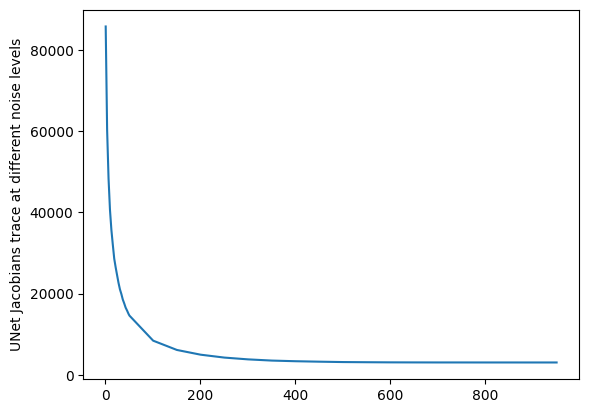

In [111]:
traces = [x.detach().cpu().numpy() for x in J_trace.values()]
plt.plot(times, traces)
plt.ylabel("trace")
plt.ylabel("noise level")
plt.ylabel("UNet Jacobians trace at different noise levels")

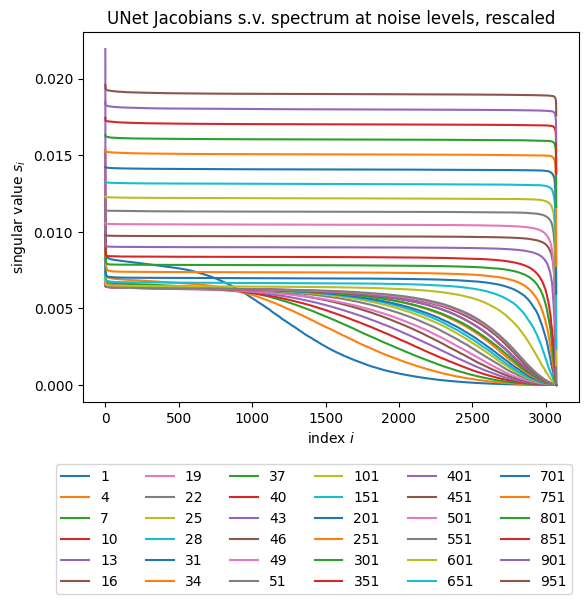

In [110]:
for t in times:
    # if t > 1: plt.plot(CURR_OUT[t], label=t)
    plt.plot(sv_cov[t], label=t)
    # plt.plot(sv, label=t)
plt.title("UNet Jacobians s.v. spectrum at noise levels, rescaled")
plt.ylabel("singular value $s_i$")
plt.xlabel("index $i$")
plt.legend(bbox_to_anchor=(1, -0.15), ncols=6)

[1, 4, 7, 10, 13, 16, 19, 22, 25, 28, 31, 34, 37, 40, 43, 46, 49, 51, 101, 151, 201, 251, 301, 351, 401, 451, 501, 551, 601, 651, 701, 751, 801, 851, 901, 951]
[tensor(26.3439), tensor(28.4999), tensor(34.0330), tensor(37.9462), tensor(39.6209), tensor(41.4002), tensor(42.2604), tensor(43.2268), tensor(44.2478), tensor(44.9803), tensor(44.8081), tensor(45.8871), tensor(45.5847), tensor(46.0010), tensor(46.7613), tensor(47.0682), tensor(46.7939), tensor(47.9819), tensor(48.5025), tensor(42.4016), tensor(37.3224), tensor(42.4143), tensor(35.2876), tensor(29.6091), tensor(22.5192), tensor(54.6764), tensor(54.5977), tensor(54.8429), tensor(54.7854), tensor(54.7811), tensor(54.7997), tensor(54.3470), tensor(54.3773), tensor(54.1189), tensor(53.9428), tensor(53.7488)]


Text(0.5, 0, 'noise level')

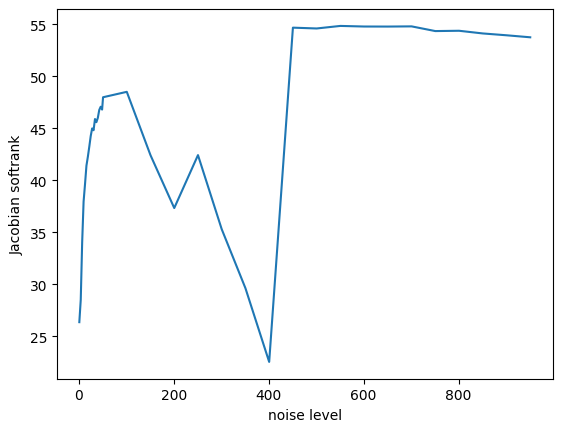

In [109]:
print(times)
softranks_cov = [softrank(sv_cov[t]) for t in times]
print(softranks_cov)
plt.plot(times, softranks_cov)
plt.ylabel("Jacobian softrank")
plt.xlabel("noise level")

## Generation

In [17]:
def get_noise():
    return torch.randn((1,3,32,32)).to(device)

x_prev = get_noise()

ddpm.unet.eval()

for t in reversed(range(1000)):
    if t > 0:
        noise = get_noise()
    else:
        noise = torch.zeros((1, 3,32,32)).to(device)

    clip_image_coeff = 1 / torch.sqrt(alphas_prod[t])
    clip_noise_coeff = torch.sqrt(1 / alphas_prod[t] - 1)
    
    image_coeff = (1 - alphas_prod[t-1]) * torch.sqrt(alphas[t]) / (1 - alphas_prod[t])
    clipe_coeff = torch.sqrt(alphas_prod[t-1]) * betas[t] / (1 - alphas_prod[t])
    

    # noise_scale = (1 - alphas[t]) / torch.sqrt(1 - alphas_prod[t]) 
    
    with torch.no_grad():
        noise_pred = ddpm.unet(x_prev, t).sample

    pred_mean = clip_image_coeff * image - clip_noise_coeff * noise_pred
    pred_mean = torch.clip(pred_mean, -1, 1)
        
    prev_image = clip_coeff * pred_mean + image_coeff * image

    x_new = (1 / torch.sqrt(alphas[t]) ) * (x_prev - noise_scale * noise_pred) + torch.sqrt(betas[t]) * z

    x_prev = x_new

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-197.58263..207.33498].


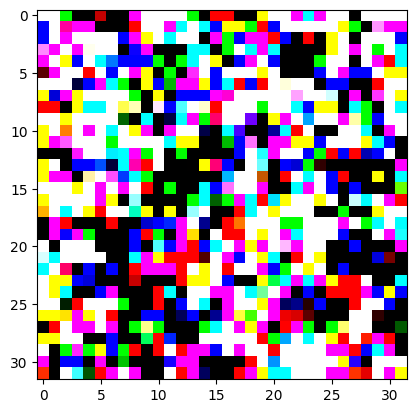

In [18]:
plt.imshow(np.moveaxis((x_new[0] / 2 + 0.5).detach().cpu().numpy(), 0, -1))